# Projecte Node21: Classificació i Detecció de Nòduls Pulmonars en Radiografies de Pit.

## Introducció
En aquest projecte abordarem la detecció de nòduls pulmonars en radiografies de tòrax (CXR) seguint l'enunciat del repte **Node21** ([enllaç al repte](https://node21.grand-challenge.org/)). El repte Node21 proporciona un conjunt de dades públic de radiografies frontals de pit amb nòduls pulmonars anotats mitjançant **caixes delimitadores** (bounding boxes). En total consta d'aproximadament **4.882 radiografies**, de les quals **1.134** contenen almenys un nòdul i **3.748** imatges no en contenen, actuant com a casos negatius.  

L'objectiu consisteix en aplicar tècniques d'aprenentatge automàtic al problema proposat. S'han definit un **conjunt de tasques seqüencials** per tal de facilitar-ne el desenvolupament:

1. **Classificació**: Desenvolupar un sistema de classificació binària capaç de determinar si una radiografia conté nòduls pulmonars. Aquesta tasca es resoldrà mitjançant l'avaluació de **quatre models diferents**, alguns d'entrenats des de zero i d'altres aprofitant tècniques de *transfer learning*.
2. **Detecció**: Implementar models de detecció per localitzar els nòduls en la imatge, identificant-ne la posició amb caixes delimitadores. Per aquesta tasca es faran servir **dues arquitectures diferents** basades en *deep learning*.
3. **Innovació**: S’obre la possibilitat d’aplicar tècniques avançades o enfocaments propis que ampliïn o millorin les metodologies aplicades.

Per abordar aquestes tasques, utilitzarem un únic *notebook* Jupyter que integrarà tot el codi i explicacions necessàries. S'empraran diverses tècniques i models d'**aprenentatge automàtic** i **aprenentatge profund** vists a classe.


## Preparació de l'entorn i dependències
Abans de començar, assegurem-nos de tenir instal·lades totes les **dependències** necessàries. El projecte requerirà les biblioteqües següents:

- **NumPy** - per a manipulació de dades numèriques i de taules (anotacions).
- **PyTorch** - per construir i entrenar els models de CNN i Transfer Learning.
- **Matplotlib** - per a la visualizació de gràfiques i imatges.
- **Os** - per a la manipulació de fitxers i rutes.
- **Pandas** - per a carregar el csv d'anotacions.
- **Simple ITK** - per a manipular les imatges amb extensió `.mha`.

Podem instal·lar els paquets que falten directament des del notebook. Per exemple:

`pip install torch torchvision scikit-learn matplotlib numpy`

També assegurarem una estructura de carpetes correcta en el directori de treball actual:

- `data/` - Contindrà les dades del NODE21 (imatges i anotacions).
- `utils/` - Codi de suport reutilitzable, com ara funcions d’augmentació, funcions d'entrenament, funcions per dibuixar caixes, etc.

## Obtenció i preparació de les dades Node21

Per dur a terme les tasques de classificació i detecció de nòduls pulmonars, utilitzarem les dades proporcionades pel repte NODE21, descarregades des del repositori oficial de Zenodo. Aquest conjunt inclou radiografies de tòrax simulades amb nòduls inserits artificialment i anotacions detallades sobre la seva posició.

A causa de la mida del conjunt complet (~35 GB), no resulta eficient entrenar directament amb totes les imatges en un entorn personal. Per això, optarem per treballar amb un subconjunt configurable del total d’imatges, mantinguent una distribució equilibrada entre imatges positives (amb nòduls) i negatives (sense nòduls), que és fonamental per garantir una bona generalització del model.

Les imatges es troben dins la carpeta:

`data/cxr_images/proccessed_data/images/`

i tenen format **.mha**. Les anotacions associades es troben al fitxer

`data/cxr_images/proccessed_data/metadata.csv`

Aquest fitxer indica, per a cada imatge, el seu nom, l'etiqueta (label per diferenciar si hi ha nòdul o no) i les coordenades **(x, y, width, height)** corresponents, en cas de no haver nòdul (label 0) el valors són de 0. Aquest enfocament ens permet construir tant:

- **Etiquetes binàries** per a classificació: 1 si hi ha algun nòdul, 0 si no.
- **Bounding boxes per detecció**: una o més caixes per imatge, o cap.

In [62]:
import os
import sys
import torch
import pandas as pd
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import importlib
import Node21_Utils as Utils
import Node21_Models as Models

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Ruta a les imatges i anotacions
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "data/cxr_images/proccessed_data/metadata.csv"

# Nombre total d'imatges a utilitzar (ajustable)
N_IMAGES = 2000  # Exemple: 2000 imatges en total (positives + negatives)
VAL_RATIO = 0.25  # 25% per a validació

# Mida d'entrada desitjada per al model
IMG_SIZE = 512
# Mida del batch
BATCH_SIZE = 32

In [63]:
# --- VERSIÓ ORIGINAL  ---
 # Carregam el CSV d'anotacions
df = pd.read_csv(ANNOTATION_FILE)

annotations_dict = {}
labels_dict = {}

for _, row in df.iterrows():
    img_id = str(row['img_name']).replace('.mha', '')  # treim extensió
    label = int(row["label"])

    # Guardam la label (si hi ha múltiples files per la mateixa imatge, max() manté 1 si hi ha qualque nòdul)
    if img_id in labels_dict:
        labels_dict[img_id] = max(labels_dict[img_id], label)
    else:
        labels_dict[img_id] = label

    # Guardam caixes només si és positiva i la caixa és vàlida
    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
        annotations_dict.setdefault(img_id, []).append(box)

# Asseguram que totes les imatges tenguin entrada a annotations_dict
for img_id in labels_dict.keys():
    annotations_dict.setdefault(img_id, [])

# Estadístiques
n_pos = sum(labels_dict[i] for i in labels_dict)
n_neg = len(labels_dict) - n_pos
print(f"Total imatges: {len(labels_dict)} | Positives: {n_pos} | Negatives: {n_neg}")

Total imatges: 4882 | Positives: 1134 | Negatives: 3748


In [64]:
# --- CODI ORIGINAL ---
img_ids = list(labels_dict.keys())
img_labels = [labels_dict[i] for i in img_ids]
if N_IMAGES > len(img_ids):
    N_IMAGES = len(img_ids)
    
_, subsampled_ids, _, _ = train_test_split(
     img_ids, img_labels, test_size=N_IMAGES, stratify=img_labels, random_state=42)

labels_subsampled = [labels_dict[i] for i in subsampled_ids]


X_train, X_val = train_test_split(subsampled_ids, test_size=VAL_RATIO, stratify=labels_subsampled, random_state=42)


print(f"Samples d'entrenament: {len(X_train)}")
print(f"Samples de validació: {len(X_val)}")

Samples d'entrenament: 1500
Samples de validació: 500


In [65]:
img_p = sitk.ReadImage("data/cxr_images/proccessed_data/images/c0875.mha")

arr_p = sitk.GetArrayFromImage(img_p)

print(f"Forma:  {arr_p.shape}")
print(f"Mínim: {arr_p.min()}")
print(f"Màxim: {arr_p.max()}")


Forma:  (1024, 1024)
Mínim: 0
Màxim: 4095


La imatge és **2D** (1024, 1024). El rang és fix i conegut **[0,4095]** (representació de 12 bits)

In [66]:
class CXRClassificationDataSet(Dataset):
    def __init__(self, img_ids, labels_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels_dict[img_id]

        # Ruta de la imatge .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        # Normalització per percentils (millora el contrast)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)

        # Redimensionar a img_size x img_size
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))

        # Convertir a tensor (1 canal, H, W) i normalitzar a [0,1]
        tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

### Dataset de classificació: `CXRClassificationDataSet`

Aquest dataset implementa un `torch.utils.data.Dataset` per carregar radiografies de tòrax en format `.mha` i preparar-les per a una tasca de classificació binària (0/1). La sortida de cada mostra és una parella `(imatge, etiqueta)` llesta per ser consumida per un `DataLoader`.


##### Inicialització (`__init__`)

El dataset rep:
- `img_ids`: llista d’identificadors d’imatge (claus per trobar fitxers i etiquetes).
- `labels_dict`: diccionari `{img_id: label}` amb l’etiqueta binària associada.
- `img_dir`: directori on es troben les imatges `.mha`.
- `img_size`: mida final de la imatge (es força a `img_size × img_size`).
- `transform`: transformacions opcionals (augmentació o normalització addicional) aplicades al tensor final.


#### Obtenció d’una mostra (`__getitem__`)

Per a un índex `idx`, es fa el següent procés:

Primer es recupera l’`img_id` i la seva etiqueta associada des de `labels_dict`. Amb aquest identificador, es construeix la ruta del fitxer `.mha` i es carrega amb SimpleITK (`sitk.ReadImage`). Posteriorment, la imatge es converteix a `numpy array` amb `sitk.GetArrayFromImage`.

A continuació s’aplica una **normalització per percentils (1% i 99%)**, que serveix per millorar el contrast i reduir l’impacte de valors extrems. Es fa:
- càlcul de `p1` i `p99`,
- retall (`clip`) de la imatge a aquest rang,
- reescalat lineal a **[0, 255]** i conversió a `uint8`.

Després, la imatge es **redimensiona** amb OpenCV a una mida fixa `img_size × img_size`. Això homogenitza totes les entrades i facilita l’entrenament del model.

Finalment, es converteix a `torch.Tensor`:
- es passa a `float`,
- s’afegeix el canal amb `unsqueeze(0)` per obtenir forma **[1, H, W]**,
- i es normalitza a **[0, 1]** dividint per 255.

Si s’han definit transformacions (`transform`), s’apliquen sobre el tensor ja preparat.


#### Format de retorn

El dataset retorna:
- `tensor`: imatge en format `torch.Tensor` amb forma **[1, img_size, img_size]** i valors a **[0, 1]**.
- `label`: etiqueta binària com a `torch.tensor(..., dtype=torch.float32)`.

Aquesta representació és compatible amb entrenament binari amb una sortida de tipus logit i funció de pèrdua com `BCEWithLogitsLoss`.


In [67]:
from torchvision import transforms
# Defineix les transformacions per evitar Shortcut Learning
# Transformacions per a Train (Augment + Normalització)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Centrat estadístic per a 1 canal
])

# Transformacions per a Val (Només normalització)
val_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Transformacions aplicades al dataset (Train i Validation)

Per millorar la capacitat de generalització del model i evitar *shortcut learning*, s’han definit transformacions diferents per al conjunt d’entrenament i el de validació.


#### Transformacions de Train

Al conjunt d’entrenament s’apliquen tècniques d’**augmentació de dades**, amb l’objectiu d’introduir variabilitat artificial i fer el model més robust a canvis no rellevants de la imatge:

- **`RandomHorizontalFlip (p=0.5)`**: simula variacions laterals del tòrax i evita que el model depengui d’una orientació fixa.
- **`RandomRotation (±10°)`**: introdueix petites rotacions que imiten variacions d’adquisició durant la captura de la radiografia.
- **`ColorJitter (brightness, contrast)`**: aplica lleugeres variacions de brillantor i contrast, millorant la robustesa davant diferències d’intensitat i condicions d’exposició.
- **`Normalize(mean=[0.5], std=[0.5])`**: centra i escala els valors del tensor, estabilitzant l’entrenament i facilitant la convergència del model.


#### Transformacions de Validation

Al conjunt de validació **no s’aplica augmentació**, per garantir una avaluació fidel del rendiment real del model. Únicament s’aplica:

- **`Normalize(mean=[0.5], std=[0.5])`**: mateixa normalització que a train, assegurant coherència estadística entre ambdós conjunts.

Aquesta separació entre augmentació en train i normalització en validation permet entrenar un model més robust sense introduir biaixos en l’avaluació.


In [68]:
train_dataset = CXRClassificationDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=train_transforms 
)

val_dataset = CXRClassificationDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512,
    transform=val_transforms    
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

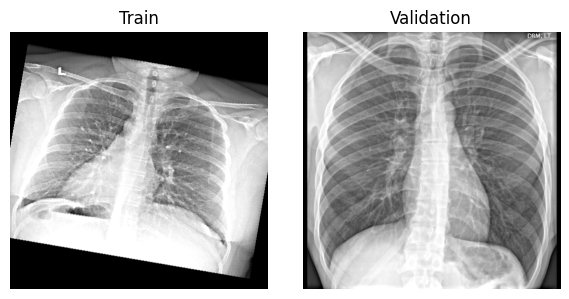

=== TRAIN IMAGE ===
Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: -1.0 1.0
Label: 1.0

=== VALIDATION IMAGE ===
Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: -1.0 1.0
Label: 0.0


In [69]:
idx = 170

img_train, label_train = train_dataset[idx]
img_val, label_val = val_dataset[idx]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Train image
axes[0].imshow(img_train.squeeze(0), cmap="gray")
axes[0].set_title("Train")
axes[0].axis("off")

# Validation image
axes[1].imshow(img_val.squeeze(0), cmap="gray")
axes[1].set_title("Validation")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Estadístiques Train
print("=== TRAIN IMAGE ===")
print("Tipus img:", type(img_train))
print("Shape img:", img_train.shape)
print("Min / Max img:", img_train.min().item(), img_train.max().item())
print("Label:", label_train.item())

# Estadístiques Validation
print("\n=== VALIDATION IMAGE ===")
print("Tipus img:", type(img_val))
print("Shape img:", img_val.shape)
print("Min / Max img:", img_val.min().item(), img_val.max().item())
print("Label:", label_val.item())


In [70]:
importlib.reload(Utils)
importlib.reload(Models)

<module 'Node21_Models' from 'C:\\Users\\pauan\\Documentos\\Universidad\\Quart\\1er Quatrimestre\\Aprenentatge Automàtic\\Node21_AA_2025-26\\Node21_Models.py'>

## Entrenament del Model 1: TinyCXRNet

cpu


Èpoques:  10%|█         | 1/10 [02:04<18:44, 124.95s/it]

[Època 1] Train loss 1.0841 acc 0.540 | Val loss 1.0649 acc 0.233


Èpoques:  20%|██        | 2/10 [04:18<17:19, 129.88s/it]

[Època 2] Train loss 1.0484 acc 0.560 | Val loss 1.0681 acc 0.250


Èpoques:  30%|███       | 3/10 [06:31<15:20, 131.56s/it]

[Època 3] Train loss 1.0353 acc 0.556 | Val loss 1.0344 acc 0.450


Èpoques:  40%|████      | 4/10 [08:47<13:18, 133.01s/it]

[Època 4] Train loss 1.0137 acc 0.623 | Val loss 1.0177 acc 0.511


Èpoques:  50%|█████     | 5/10 [10:50<10:46, 129.39s/it]

[Època 5] Train loss 1.0019 acc 0.603 | Val loss 1.0004 acc 0.637


Èpoques:  60%|██████    | 6/10 [13:10<08:52, 133.17s/it]

[Època 6] Train loss 0.9668 acc 0.666 | Val loss 0.9633 acc 0.720


Èpoques:  70%|███████   | 7/10 [15:28<06:44, 134.81s/it]

[Època 7] Train loss 0.9059 acc 0.704 | Val loss 0.9003 acc 0.777


Èpoques:  80%|████████  | 8/10 [17:37<04:25, 132.87s/it]

[Època 8] Train loss 0.8498 acc 0.761 | Val loss 0.7879 acc 0.773


Èpoques:  90%|█████████ | 9/10 [19:40<02:09, 129.95s/it]

[Època 9] Train loss 0.7385 acc 0.787 | Val loss 0.7148 acc 0.883


Èpoques: 100%|██████████| 10/10 [21:48<00:00, 130.83s/it]

[Època 10] Train loss 0.6329 acc 0.811 | Val loss 0.5168 acc 0.839


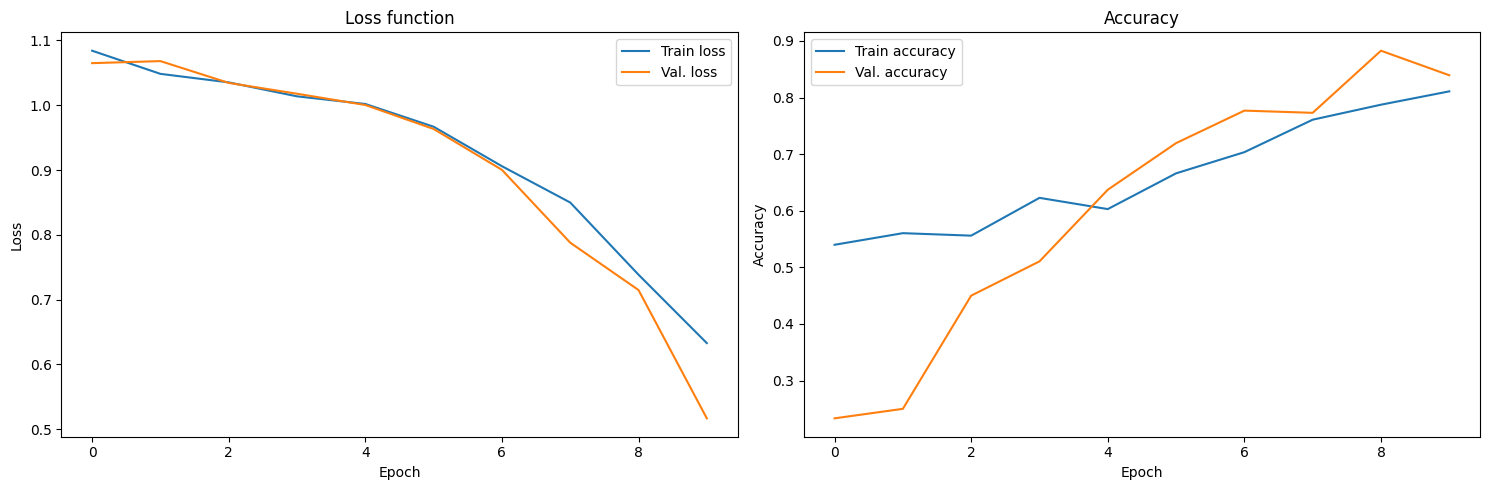

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

TinyCXR_model = Models.TinyCXRNet().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer = Utils.make_optimizer(TinyCXR_model, lr=1e-4, weight_decay=1e-4)

history = Utils.fit(
    model=TinyCXR_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device,
)

Utils.plot_training_history(history=history)

## Entrenament del Model 2: ResNet18Binary

cpu


Èpoques:  20%|██        | 1/5 [05:13<20:53, 313.28s/it]

[Època 1] Train loss 1.0622 acc 0.340 | Val loss 1.0640 acc 0.231


Èpoques:  40%|████      | 2/5 [11:06<16:50, 337.00s/it]

[Època 2] Train loss 1.0028 acc 0.624 | Val loss 1.0063 acc 0.424


Èpoques:  60%|██████    | 3/5 [16:56<11:25, 342.97s/it]

[Època 3] Train loss 0.9076 acc 0.716 | Val loss 0.8909 acc 0.659


Èpoques:  80%|████████  | 4/5 [22:40<05:43, 343.26s/it]

[Època 4] Train loss 0.7687 acc 0.786 | Val loss 0.7338 acc 0.761


Èpoques: 100%|██████████| 5/5 [27:54<00:00, 334.83s/it]

[Època 5] Train loss 0.6090 acc 0.836 | Val loss 0.6018 acc 0.883


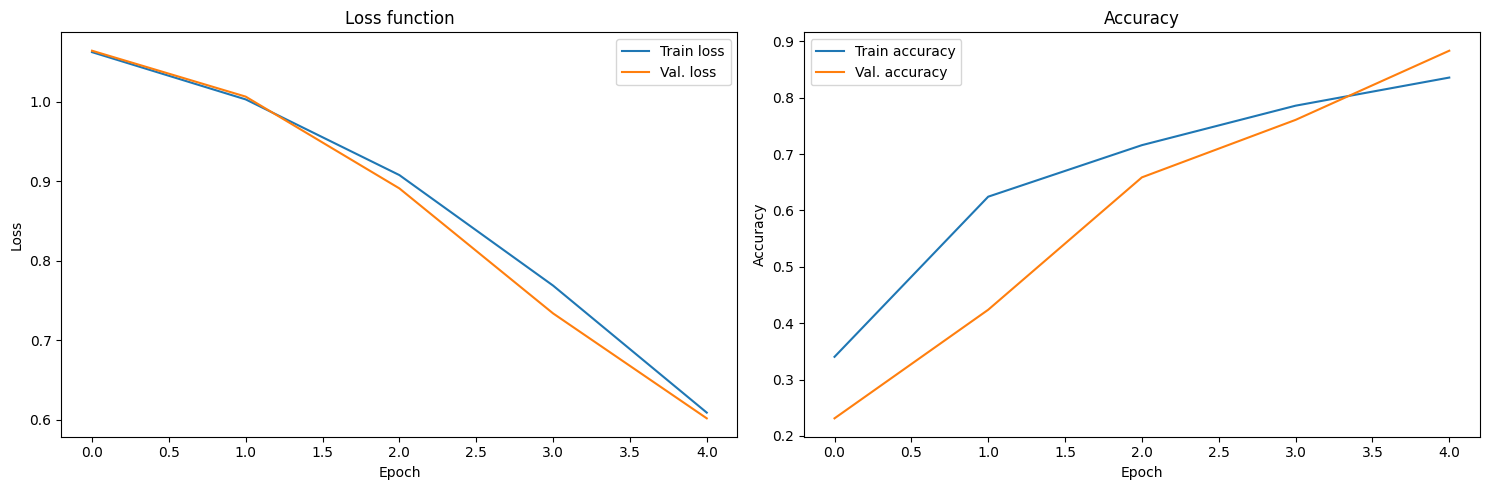

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ResNet_model = Models.ResNet18Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer = Utils.make_optimizer(ResNet_model, lr=1e-5, weight_decay=5e-2)

history = Utils.fit(
    model=ResNet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device,
)

Utils.plot_training_history(history=history)

## Entrenament del Model 3: DenseNet121Binary

cpu
Entrenant Model 3: DenseNet121...


Èpoques:  20%|██        | 1/5 [15:29<1:01:58, 929.63s/it]

[Època 1] Train loss 1.0469 acc 0.645 | Val loss 1.0418 acc 0.330


Èpoques:  40%|████      | 2/5 [30:40<45:56, 918.84s/it]  

[Època 2] Train loss 0.9954 acc 0.598 | Val loss 0.9857 acc 0.589


Èpoques:  60%|██████    | 3/5 [45:49<30:28, 914.23s/it]

[Època 3] Train loss 0.8859 acc 0.736 | Val loss 0.8747 acc 0.762


Èpoques:  80%|████████  | 4/5 [1:01:06<15:15, 915.43s/it]

[Època 4] Train loss 0.7164 acc 0.819 | Val loss 0.6812 acc 0.859


Èpoques: 100%|██████████| 5/5 [1:16:20<00:00, 916.03s/it]

[Època 5] Train loss 0.5205 acc 0.890 | Val loss 0.5087 acc 0.942


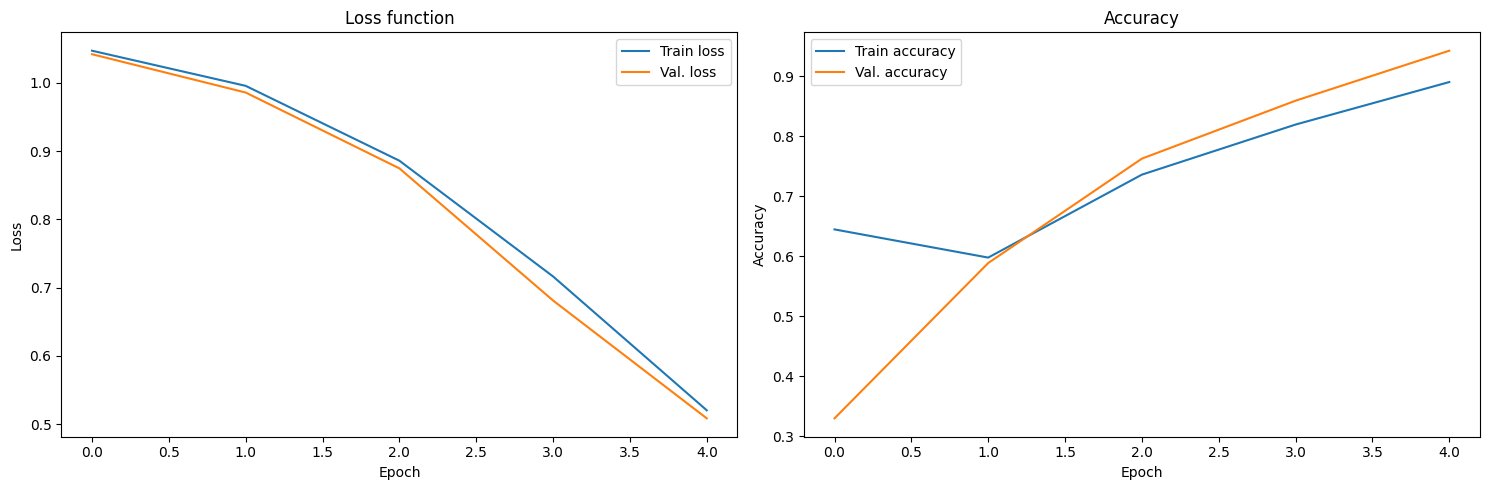

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DenseNet_model = Models.DenseNet121Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer3 = Utils.make_optimizer_denseNet(DenseNet_model, lr=1e-5, weight_decay=1e-2)

# Entrenament
print("Entrenant Model 3: DenseNet121...")
history3 = Utils.fit(
    model=DenseNet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer3,
    epochs=5,
    device=device,
)

Utils.plot_training_history(history=history3)
#Utils.plot_confusion_matrix(model3, val_loader, device)

## Entrenament del Model 4: InceptionV3Binary

cpu


Èpoques:  20%|██        | 1/5 [11:23<45:34, 683.66s/it]

[Època 1] Train loss 1.0255 acc 0.666 | Val loss 0.9726 acc 0.756


Èpoques:  40%|████      | 2/5 [23:06<34:45, 695.20s/it]

[Època 2] Train loss 0.7181 acc 0.791 | Val loss 0.6792 acc 0.903


Èpoques:  60%|██████    | 3/5 [35:16<23:41, 710.79s/it]

[Època 3] Train loss 0.3173 acc 0.932 | Val loss 0.2667 acc 0.914


Èpoques:  80%|████████  | 4/5 [46:39<11:39, 699.82s/it]

[Època 4] Train loss 0.2137 acc 0.951 | Val loss 0.1435 acc 0.970


Èpoques: 100%|██████████| 5/5 [57:46<00:00, 693.38s/it]

[Època 5] Train loss 0.1914 acc 0.961 | Val loss 0.1568 acc 0.957


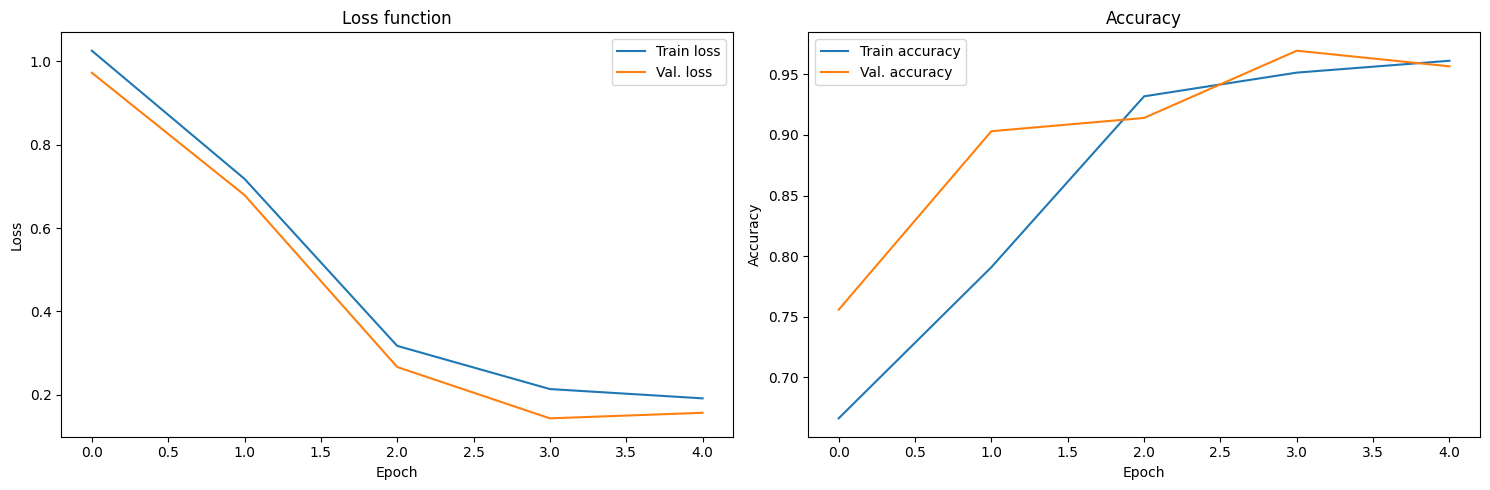

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Inception_model = Models.InceptionV3Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)

loss_fn = Utils.make_loss(pos_weight)

optimizer4 = Utils.make_optimizer(Inception_model, lr=5e-5, weight_decay=5e-2)

# Entrenament
history4 = Utils.fit(
    model=Inception_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer4,
    epochs=5,
    device=device
)

Utils.plot_training_history(history4)
#Utils.plot_confusion_matrix(Inception_model, val_loader, device)

## Classificació

### Model 1

#### Capes de `TinyCXRNet` per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: xarxa convolucional lleugera que extreu patrons visuals rellevants de la imatge i retorna un únic **logit** que es transforma en probabilitat mitjançant una funció sigmoide.

Les **capes convolucionals 3×3** (`nn.Conv2d`) són les encarregades d’extreure patrons locals de la imatge, com vores, textures i petites variacions d’intensitat, que són especialment rellevants en radiografies pulmonars.

- L’ús de kernels **3×3** permet capturar context local amb pocs paràmetres, i el `padding=1` manté la mida espacial de la imatge després de la convolució, evitant pèrdua d’informació als marges.

A mesura que la **resolució espacial** es redueix, augmenta el nombre de canals (16 → 32 → 64 → 128) per mantenir la capacitat representacional del model.

- Els primers canals capturen patrons simples.
- Els canals més profunds combinen aquests patrons per descriure estructures més complexes i regions potencialment anòmales.


La **Batch Normalization** (`nn.BatchNorm2d`) s’utilitza per estabilitzar l’entrenament i reduir la variabilitat interna de les activacions. En imatges mèdiques, on poden existir diferències d’adquisició i contrast, aquesta capa ajuda a fer el model més robust i accelera la convergència durant l’entrenament.


El **MaxPool (`nn.MaxPool2d(2)`)** redueix la resolució espacial i el cost computacional, alhora que augmenta el camp receptiu de les capes profundes.

En aquest model s’apliquen tres operacions de MaxPool (512→256→128→64). No s’aplica un quart pooling final per evitar perdre massa detall espacial, ja que els nòduls poden ser estructures relativament petites.

Les **capes** `AdaptiveAvgPool2d` i `AdaptiveMaxPool2d` transformen els mapes de característiques finals a una mida fixa **4×4**, independentment de la resolució d’entrada, fent el model més flexible.

- **AdaptiveAvgPool2d** aporta informació global i context general de la imatge.
- **AdaptiveMaxPool2d** preserva activacions locals fortes, útils per detectar lesions petites.

La concatenació d’ambdues sortides combina context global i informació local en una única representació més rica.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització per reduir el risc de sobreajust. És especialment útil en contextos mèdics, on els conjunts de dades solen ser limitats o desbalancejats, ja que obliga el model a no dependre excessivament d’un subconjunt concret de neurones.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària.

### Model 2

#### Capes de `ResNet18Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en **transfer learning**, que reutilitza una xarxa profunda preentrenada (`ResNet18`) per extreure característiques visuals robustes, adaptant-la posteriorment al problema específic de detecció de nòduls mitjançant un capçal binari amb un únic **logit**.


Aquest model utilitza **ResNet18 preentrenada en ImageNet** com a *backbone*. El transfer learning permet aprofitar característiques visuals apreses prèviament sobre un conjunt molt gran d’imatges, com detectors de vores, textures i formes generals, que també són útils en radiografies mèdiques.

L’avantatge principal d’aquest enfocament és que el model **no parteix de zero**, fet especialment important en contextos mèdics on la quantitat de dades etiquetades sol ser limitada. Això acostuma a millorar la capacitat de generalització i accelera la convergència durant l’entrenament.


La primera capa convolucional de ResNet18 s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats, ajustant-los al domini CXR de manera coherent.


El *backbone* ResNet18 està format per **blocs residuals**, que introdueixen connexions directes entre capes. Aquestes connexions residuals faciliten l’entrenament de xarxes profundes, eviten problemes de degradació del gradient i permeten aprendre representacions més estables i riques que en una CNN simple.

Gràcies a aquesta estructura, el model pot capturar tant **patrons locals** com **context global**, aspecte clau en radiografies pulmonars, on la presència d’un nòdul pot dependre tant d’una petita regió local com del context anatòmic que l’envolta.


El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:

- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per ResNet18 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.


El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.


L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.


En conjunt, aquest segon model permet comparar un enfocament **des de zero (Model 1)** amb un enfocament basat en **transfer learning (Model 2)**, analitzant l’impacte de reutilitzar coneixement previ en la detecció automàtica de nòduls en radiografies de tòrax.


### Model 3

#### Capes de `DenseNet121Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **DenseNet121** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar filtres visuals complexos ja optimitzats, adaptant la xarxa a la naturalesa específica de les imatges mèdiques mitjançant una reconfiguració de la seva topologia d'entrada i del seu capçal final.

Aquest model es diferencia de les arquitectures residuals convencionals pel seu ús de **blocs densos** (Dense Blocks). En aquestes estructures, cada capa rep com a entrada els mapes de característiques de totes les capes anteriors i passa els seus propis mapes a totes les següents. 

L'avantatge principal d'aquesta **connectivitat extrema** per a la detecció de nòduls és:

- Millora el **flux de gradients** i d'informació a través de tota la xarxa, reduint el risc de desaparició del gradient.
- Fomenta la **reutilització de característiques** (*feature reuse*), permetent que detalls fins de la textura del nòdul es mantinguin disponibles per a les capes més profundes.
- Produeix un model amb **menys paràmetres** que una ResNet equivalent, cosa que ajuda a mitigar el **sobreajust (overfitting)** en el dataset Node21.

La primera capa convolucional de la DenseNet s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per DenseNet121 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest tercer model permet comparar diferents arquitectures de transfer learning (ResNet vs DenseNet) i avaluar quin enfocament és més efectiu per a la detecció automàtica de nòduls en radiografies de tòrax.

### Model 4

#### Capes de `InceptionV3Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 299, 299]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en l'arquitectura **InceptionV3** preentrenada en ImageNet. Aquest enfocament utilitza el **transfer learning** per aprofitar la seva capacitat de processament multi-escala, adaptant la xarxa per detectar nòduls de mides variables mitjançant una reconfiguració de la mida d'entrada i del capçal final.



A diferència de les arquitectures lineals o residuals, la **InceptionV3** utilitza mòduls que executen diverses operacions convolucionals en paral·lel ($1\times1, 3\times3, 5\times5$).

L'avantatge principal d'aquest enfocament **multi-escala** per a la detecció de nòduls és:

- Permet capturar **característiques a diferents resolucions** simultàniament, essent ideal per a nòduls que poden presentar-se amb diàmetres molt dispars.
- L'ús de convolucions factoritzades (com $1\times7$ i $7\times1$) ajuda a reduir el cost computacional i el sobreajust mentre s'aprofundeix en la representació del teixit pulmonar.
- El model inclou **classificadors auxiliars** (durant l'entrenament) que ajuden a combatre la desaparició del gradient i milloren la convergència en xarxes tan profundes.

La primera capa convolucional s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats del *backbone* que originalment esperaven tres canals (RGB).

El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:
- una capa lineal intermèdia que integra les característiques extretes pel backbone
- una activació ReLU que introdueix no linealitat
- una capa de Dropout per reduir el sobreajust
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per InceptionV3 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.

En conjunt, aquest quart model permet explorar com una arquitectura profundament multi-escala com InceptionV3 pot millorar la detecció automàtica de nòduls en radiografies de tòrax, especialment quan aquests poden variar significativament en mida i aparença.

## Detecció

In [5]:
class CXRDetectorDataSet(Dataset):
    """
    Dataset per detecció (torchvision SSD/FasterRCNN):
    retorna (image, target)

    - image: FloatTensor [3, H, W] en [0,1]
    - target:
        boxes: FloatTensor [N,4] (x1,y1,x2,y2) en píxels
        labels: Int64Tensor [N] (1=nòdul)
        image_id: Int64Tensor [1]
        area: FloatTensor [N]
        iscrowd: Int64Tensor [N]
    """
    
    def __init__(self, img_ids, labels_dict, annotations_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.annotations_dict = annotations_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = int(self.labels_dict[img_id])  # 0/1
        boxes_xywh = self.annotations_dict.get(img_id, [])  # llista de [x,y,w,h] en coords originals (1024)
        
        # --- Load .mha ---
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        H0, W0 = arr.shape  # normalment 1024,1024
        
        # --- Normalització per percentils -> [0,255] uint8 ---
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1 + 1e-8)) * 255.0
        arr = arr.astype(np.uint8)

        # --- Resize imatge a img_size x img_size ---
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
        
        # --- Tensor imatge: [1,H,W] -> [3,H,W] (SSD preentrenat espera 3 canals) ---
        image = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255.0   # [1,H,W]
        image = image.repeat(3, 1, 1)                                        # [3,H,W]

        if self.transform:
            image = self.transform(image)

        # --- Construir target ---
        # Convertim boxes de (x,y,w,h) -> (x1,y1,x2,y2) i reescalam al resize
        sx = self.img_size / float(W0)
        sy = self.img_size / float(H0)

        boxes = []
        if label == 1 and len(boxes_xywh) > 0:
            for (x, y, w, h) in boxes_xywh:
                x1 = x * sx
                y1 = y * sy
                x2 = (x + w) * sx
                y2 = (y + h) * sy
                
                # clamp per seguretat
                x1 = max(0.0, min(x1, self.img_size - 1.0))
                y1 = max(0.0, min(y1, self.img_size - 1.0))
                x2 = max(0.0, min(x2, self.img_size - 1.0))
                y2 = max(0.0, min(y2, self.img_size - 1.0))

                # Filtre bàsic: evitar caixes degenerades
                if (x2 - x1) >= 1.0 and (y2 - y1) >= 1.0:
                    boxes.append([x1, y1, x2, y2])

        if len(boxes) == 0:
            # IMPORTANT: en torchvision detection, negatives han de dur caixes buides i labels buits
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # 1 = nòdul
            area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": area,
            "iscrowd": iscrowd,
        }

        return image, target

def detection_collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

### Dataset de detecció: `CXRDetectorDataSet`

Aquest dataset està dissenyat per a **detecció de nòduls** amb models de `torchvision`, i retorna per a cada mostra una parella `(image, target)` amb el format esperat per aquests detectors.


#### Objectiu i format general

- **Entrada**: radiografies de tòrax en format `.mha`.
- **Sortida**:
  - `image`: tensor **[3, H, W]** amb valors a **[0, 1]**.
  - `target`: diccionari amb caixes delimitadores i metadades associades (format estàndard de detecció).

Aquest enfocament permet no només indicar si hi ha un nòdul, sinó **localitzar-lo espacialment** dins la imatge.


#### Càrrega i preprocessat de la imatge

La imatge es carrega amb **SimpleITK** i es converteix a `numpy array`. A continuació, s’aplica una **normalització per percentils (1%–99%)** per millorar el contrast i reduir l’impacte de valors extrems. Després, la imatge es reescala a l’interval **[0, 255]** i es converteix a `uint8`.

La imatge es **redimensiona** a una mida fixa (`img_size × img_size`) per garantir coherència entre mostres i compatibilitat amb el model de detecció.


#### Conversió a tensor i canals

La imatge redimensionada es transforma a `torch.Tensor`, es normalitza a **[0, 1]** i inicialment es representa amb un sol canal **[1, H, W]**.  

Com que els models de detecció preentrenats esperen **3 canals**, el canal únic es replica per obtenir una entrada **[3, H, W]**, permetent reutilitzar directament els pesos preentrenats (*transfer learning*).

Si s’han definit transformacions addicionals (`transform`), aquestes s’apliquen sobre el tensor final.


#### Gestió de les anotacions (bounding boxes)

Les anotacions originals es proporcionen en format **(x, y, w, h)** i en coordenades de la imatge original. Aquestes caixes es:

- converteixen a format **(x1, y1, x2, y2)**,
- reescales segons el factor de redimensionament de la imatge,
- i es limiten (*clamp*) als marges de la imatge per seguretat.

Només es conserven caixes vàlides (amb amplada i alçada mínimes).


#### Construcció del `target`

El diccionari `target` inclou:
- `boxes`: tensor **[N, 4]** amb les caixes delimitadores.
- `labels`: tensor **[N]** amb l’etiqueta de classe (`1` = nòdul).
- `image_id`: identificador de la imatge.
- `area`: àrea de cada caixa.
- `iscrowd`: indicador requerit per l’API de detecció.

En el cas d’imatges **negatives** (sense nòduls), es retornen tensors buits, tal com exigeix l’API de detecció de `torchvision`.


#### Collate function per detecció

La funció `detection_collate_fn` agrupa les mostres en **llistes d’imatges i targets**, en lloc de tensors apilats, que és el format requerit pels models de detecció durant l’entrenament i la inferència.


En conjunt, aquest dataset prepara les radiografies i les seves anotacions perquè siguin directament compatibles amb models de detecció basats en **transfer learning**, permetent entrenar xarxes que no només detecten la presència d’un nòdul, sinó que també en localitzen la posició dins la imatge.


In [6]:
import random
from torch.utils.data import Subset, DataLoader

BATCH_SIZE = 16 # Nou batch size per detecció
pos_indices = []
neg_indices = []

for i, img_id in enumerate(X_train):
    if img_id in annotations_dict and len(annotations_dict[img_id]) > 0:
        pos_indices.append(i)
    else:
        neg_indices.append(i)

print(f"Resultat del filtre:")
print(f"- Imatges amb nòduls (positives): {len(pos_indices)}")
print(f"- Imatges sense nòduls (negatives): {len(neg_indices)}")

random.seed(42) 
if len(neg_indices) >= len(pos_indices):
    selected_neg_indices = random.sample(neg_indices, len(pos_indices))
else:
    selected_neg_indices = neg_indices

mix_indices = pos_indices + selected_neg_indices
print(f"- Total imatges Mix (Fase 2): {len(mix_indices)} (Equilibri 1:1)")

train_det_dataset = CXRDetectorDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    annotations_dict=annotations_dict,
    img_dir=IMG_DIR,
    img_size=IMG_SIZE,
)

val_det_dataset = CXRDetectorDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    annotations_dict=annotations_dict,
    img_dir=IMG_DIR,
    img_size=IMG_SIZE,
)

# FASE 1: Només imatges amb nòduls
train_pos_loader = DataLoader(
    Subset(train_det_dataset, pos_indices),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=detection_collate_fn
)

# FASE 2: Mix equilibrat per evitar falsos positius
train_mix_loader = DataLoader(
    Subset(train_det_dataset, mix_indices),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=detection_collate_fn
)

val_det_loader = DataLoader(
    val_det_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=detection_collate_fn
)

Resultat del filtre:
- Imatges amb nòduls (positives): 349
- Imatges sense nòduls (negatives): 1151
- Total imatges Mix (Fase 2): 698 (Equilibri 1:1)


### Preparació del conjunt d’entrenament per a detecció de nòduls

En la tasca de detecció de nòduls, el conjunt de dades presenta un **desbalanç important** entre imatges amb nòduls (positives) i imatges sense nòduls (negatives). Aquest desbalanç pot provocar que el model aprengui a predir majoritàriament *background*, generant molts falsos positius o falsos negatius.

Per aquest motiu, es defineix una estratègia d’entrenament en **dues fases**, basada en un filtratge i equilibratge explícit de les mostres.


#### Separació d’imatges positives i negatives

Primer es recorren les imatges del conjunt d’entrenament i es separen els índexs en dos grups:

- **Positives**: imatges que tenen anotacions de nòduls (`annotations_dict` no buit).
- **Negatives**: imatges sense cap anotació.

Això permet identificar clarament quines imatges contenen nòduls i quines no.


#### Equilibratge del conjunt d’entrenament

Donat que el nombre d’imatges negatives és molt superior al de positives, es fa un **mostreig aleatori de negatives** per igualar el nombre de positives, obtenint un conjunt **equilibrat 1:1**.

Aquest pas evita que el model es vegi dominat per exemples sense nòduls i ajuda a reduir la tendència a predir sempre *background*.


#### Entrenament en dues fases

S’utilitzen dos `DataLoader` diferents per entrenar el model de detecció:

- **Fase 1 – només positives**  
  El model s’entrena únicament amb imatges que contenen nòduls.  
  Això permet que aprengui a detectar correctament patrons associats als nòduls i a ajustar les caixes delimitadores sense la interferència d’imatges buides.

- **Fase 2 – conjunt mixt equilibrat**  
  S’entrena amb una combinació equilibrada d’imatges positives i negatives.  
  Aquesta fase ajuda el model a aprendre a distingir entre nòduls reals i *background*, reduint el nombre de falsos positius.


#### Conjunt de validació

El conjunt de validació no s’equilibra artificialment. Es manté amb la seva distribució original per obtenir una **avaluació realista** del rendiment del model en un escenari similar al d’ús final.


L’ús de `Subset` i `DataLoader` facilita la implementació d’aquesta separació i l’entrenament per fases sense modificar el dataset original.


Tipus image: <class 'torch.Tensor'>
Shape image: torch.Size([3, 512, 512])

Target keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])
Labels: tensor([1, 1, 1])
Boxes: tensor([[144.5000, 115.0000, 167.5000, 142.0000],
        [ 80.5000, 330.5000, 101.0000, 354.0000],
        [313.5000, 291.5000, 331.5000, 315.0000]])


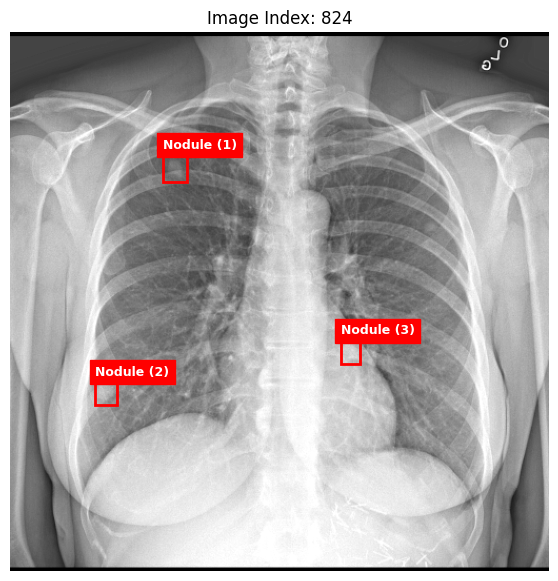

In [7]:
import matplotlib.patches as patches

idx = 824
image, target = train_det_dataset[idx]

# Debugging del contingut
print("Tipus image:", type(image))
print("Shape image:", image.shape)          # [3, H, W]
print("\nTarget keys:", target.keys())
print("Labels:", target["labels"])          
print("Boxes:", target["boxes"])            

# Preparació de la imatge: Agafem el primer canal i passem a numpy
# image[0] selecciona el primer canal [H, W]
img_np = image[0].cpu().numpy() 

# Crear la figura
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.imshow(img_np, cmap="gray")
ax.set_title(f"Image Index: {idx}") # O X_train[idx] si tens la llista d'IDs a mà
ax.axis("off")

boxes = target["boxes"]
labels = target["labels"]

# Iterem utilitzant el rang per poder accedir a 'labels' correctament
for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i].tolist()
    w = x2 - x1
    h = y2 - y1

    # Dibuixar el rectangle
    rect = patches.Rectangle(
        (x1, y1),
        w,
        h,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

    # Afegir l'etiqueta amb el valor de la label (labels[i].item())
    ax.text(
        x1,
        y1 - 5,
        f"Nodule ({i+1})",
        color="white",
        fontsize=9,
        fontweight='bold',
        backgroundcolor="red" # El vermell destaca millor sobre el gris
    )

plt.show()

In [8]:
importlib.reload(Utils)
importlib.reload(Models)

<module 'Node21_Models' from 'C:\\Users\\pauan\\Documentos\\Universidad\\Quart\\1er Quatrimestre\\Aprenentatge Automàtic\\Node21_AA_2025-26\\Node21_Models.py'>

## Entrenament del Model 1 de Detecció: RetinaNetDetector


In [9]:
# Fase 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

RetinaNet_model = Models.RetinaNetDetector().to(device)

optimizer = Utils.make_optimizer_detection(RetinaNet_model, lr=1e-2,momentum=0.9, weight_decay=5e-4)

print("Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...")
history = Utils.fit_det(
    model=RetinaNet_model,
    train_loader=train_pos_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(RetinaNet_model.state_dict(), "retinanet_phase1.pth")

cpu
Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...


Èpoques:  20%|██        | 1/5 [07:38<30:33, 458.50s/it]

[Època 1] Train loss 2.0393 (classification:1.0892 | bbox_regression:0.9501)  ||  Val loss 0.4894 (classification:0.2701 | bbox_regression:0.2193)


Èpoques:  40%|████      | 2/5 [15:14<22:50, 456.85s/it]

[Època 2] Train loss 1.8174 (classification:0.9616 | bbox_regression:0.8558)  ||  Val loss 0.4924 (classification:0.2800 | bbox_regression:0.2124)


Èpoques:  60%|██████    | 3/5 [22:38<15:02, 451.13s/it]

[Època 3] Train loss 1.8680 (classification:0.9982 | bbox_regression:0.8697)  ||  Val loss 0.6232 (classification:0.4110 | bbox_regression:0.2122)


Èpoques:  80%|████████  | 4/5 [30:39<07:43, 463.10s/it]

[Època 4] Train loss 1.6659 (classification:0.8456 | bbox_regression:0.8203)  ||  Val loss 0.5299 (classification:0.3292 | bbox_regression:0.2007)


Èpoques: 100%|██████████| 5/5 [38:36<00:00, 463.37s/it]

[Època 5] Train loss 1.5631 (classification:0.7757 | bbox_regression:0.7873)  ||  Val loss 0.4286 (classification:0.2247 | bbox_regression:0.2039)


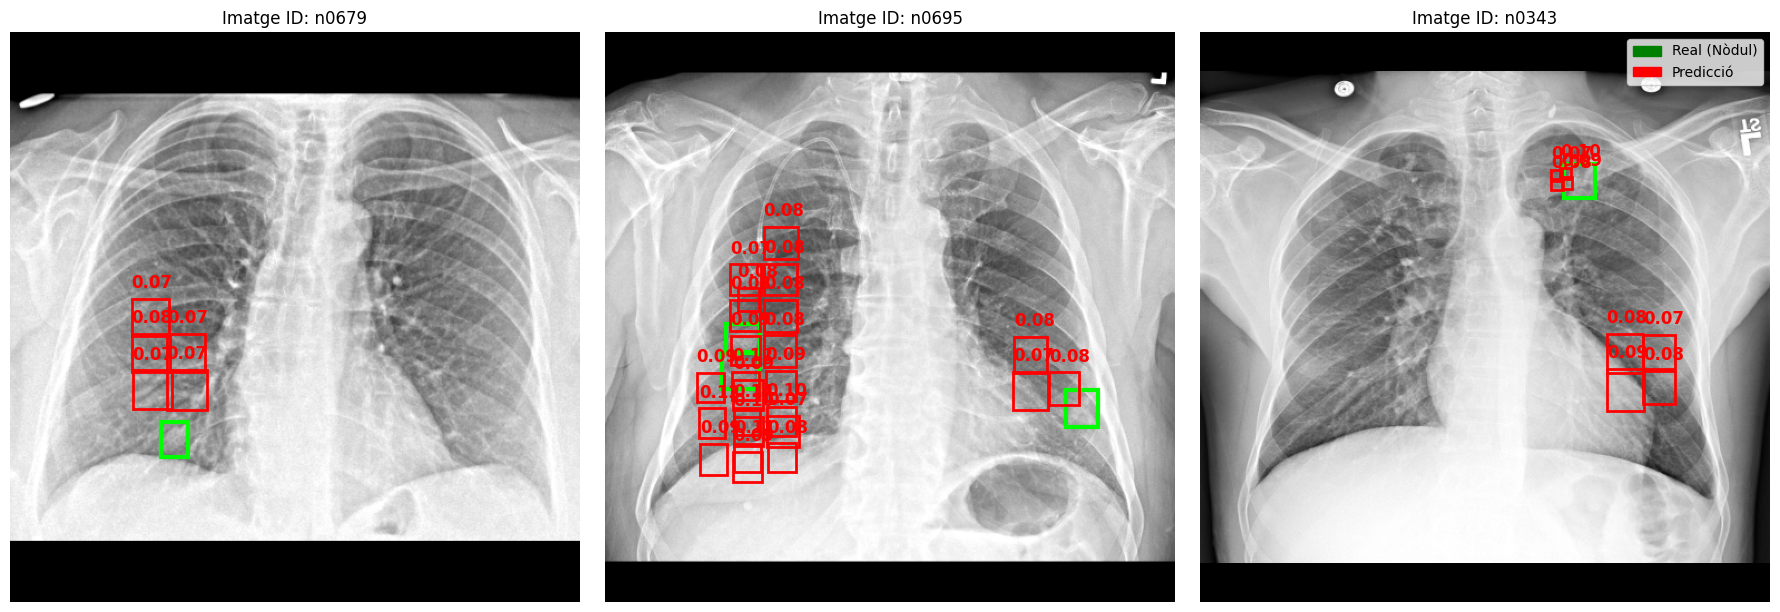

In [14]:
Utils.visualize_positive_predictions(RetinaNet_model, val_det_dataset, device, num_images=3, threshold=0.07)

In [10]:
# Fase 2: Refinament amb imatges positives i negatives (mix equilibrat)

optimizer = Utils.make_optimizer_detection(RetinaNet_model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

print("\nIniciant FASE 2: Refinament amb imatges sanes i malaltes...")
history2 = Utils.fit_det(
    model=RetinaNet_model,
    train_loader=train_mix_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(RetinaNet_model.state_dict(), "retinanet_phase2.pth")


Iniciant FASE 2: Refinament amb imatges sanes i malaltes...


Èpoques:  20%|██        | 1/5 [13:00<52:01, 780.49s/it]

[Època 1] Train loss 0.7183 (classification:0.3735 | bbox_regression:0.3447)  ||  Val loss 0.4403 (classification:0.2428 | bbox_regression:0.1974)


Èpoques:  40%|████      | 2/5 [25:54<38:49, 776.63s/it]

[Època 2] Train loss 0.6631 (classification:0.3487 | bbox_regression:0.3144)  ||  Val loss 0.4363 (classification:0.2389 | bbox_regression:0.1974)


Èpoques:  60%|██████    | 3/5 [38:44<25:46, 773.49s/it]

[Època 3] Train loss 0.6290 (classification:0.3342 | bbox_regression:0.2948)  ||  Val loss 0.4316 (classification:0.2331 | bbox_regression:0.1985)


Èpoques:  80%|████████  | 4/5 [50:07<12:17, 737.75s/it]

[Època 4] Train loss 0.5891 (classification:0.3123 | bbox_regression:0.2767)  ||  Val loss 0.4253 (classification:0.2286 | bbox_regression:0.1967)


Èpoques: 100%|██████████| 5/5 [1:01:37<00:00, 739.55s/it]

[Època 5] Train loss 0.5624 (classification:0.2955 | bbox_regression:0.2669)  ||  Val loss 0.4286 (classification:0.2302 | bbox_regression:0.1984)


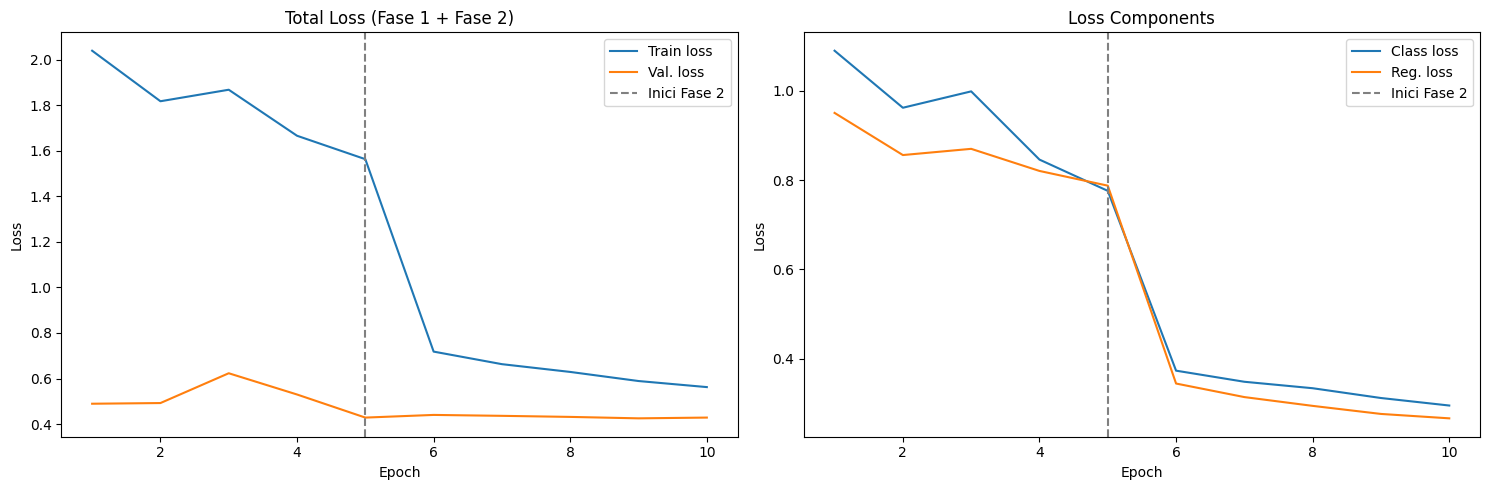

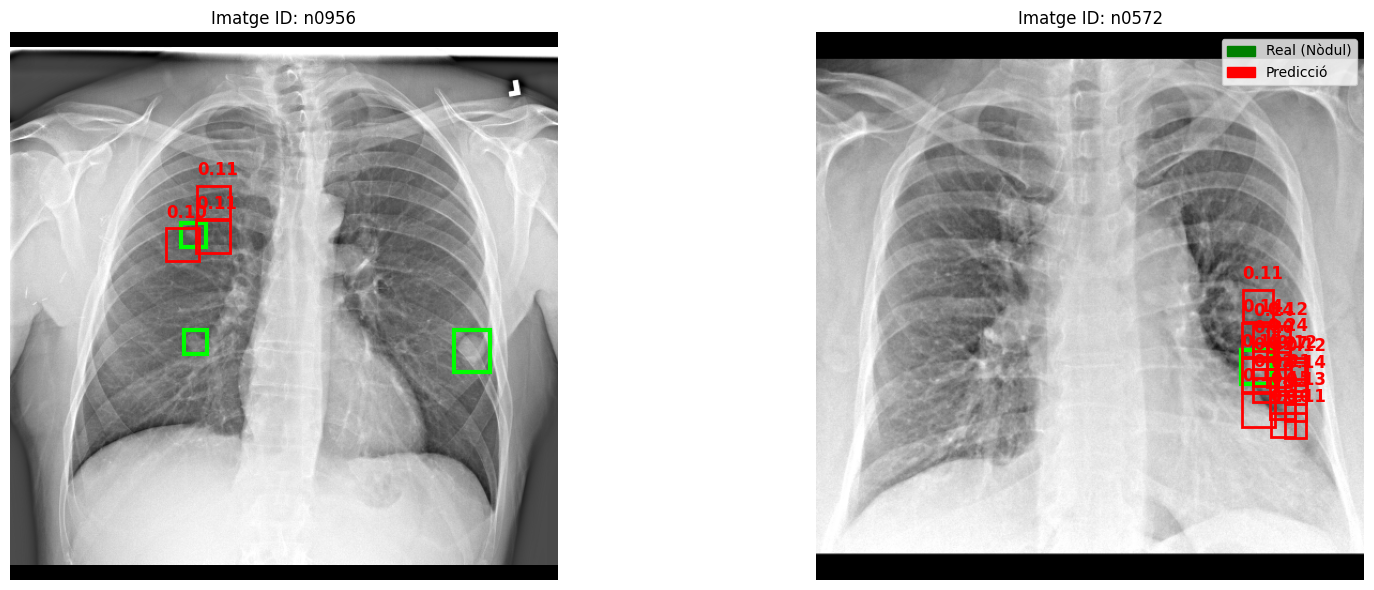

In [33]:
Utils.plot_combined_history(history, history2)
Utils.visualize_positive_predictions(RetinaNet_model, val_det_dataset, device, num_images=2, threshold=0.10)


## Entrenament del Model 2 de Detecció: SSD300VGG16Detector

In [36]:
# Fase 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

SSDVGG_model = Models.SSD300VGG16Detector().to(device)

optimizer = Utils.make_optimizer_detection(SSDVGG_model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

print("Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...")
history = Utils.fit_det(
    model=SSDVGG_model,
    train_loader=train_pos_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(SSDVGG_model.state_dict(), "ssdvgg16_phase1.pth")

cpu
Iniciant FASE 1: Entrenament 'agressiu' només amb imatges positives (amb nòduls)...


Èpoques:  20%|██        | 1/5 [03:15<13:00, 195.14s/it]

[Època 1] Train loss 7.3569 (bbox_regression:3.2185 | classification:4.1384)  ||  Val loss 4.6697 (bbox_regression:2.4189 | classification:2.2508)


Èpoques:  40%|████      | 2/5 [06:36<09:56, 198.77s/it]

[Època 2] Train loss 5.4505 (bbox_regression:2.8782 | classification:2.5723)  ||  Val loss 4.1021 (bbox_regression:2.0443 | classification:2.0577)


Èpoques:  60%|██████    | 3/5 [10:16<06:56, 208.50s/it]

[Època 3] Train loss 4.7436 (bbox_regression:2.2968 | classification:2.4468)  ||  Val loss 3.4786 (bbox_regression:1.4753 | classification:2.0033)


Èpoques:  80%|████████  | 4/5 [13:31<03:23, 203.20s/it]

[Època 4] Train loss 4.0951 (bbox_regression:1.6977 | classification:2.3974)  ||  Val loss 3.3772 (bbox_regression:1.3503 | classification:2.0269)


Èpoques: 100%|██████████| 5/5 [17:02<00:00, 204.51s/it]

[Època 5] Train loss 3.6663 (bbox_regression:1.3106 | classification:2.3557)  ||  Val loss 3.2503 (bbox_regression:1.2832 | classification:1.9671)


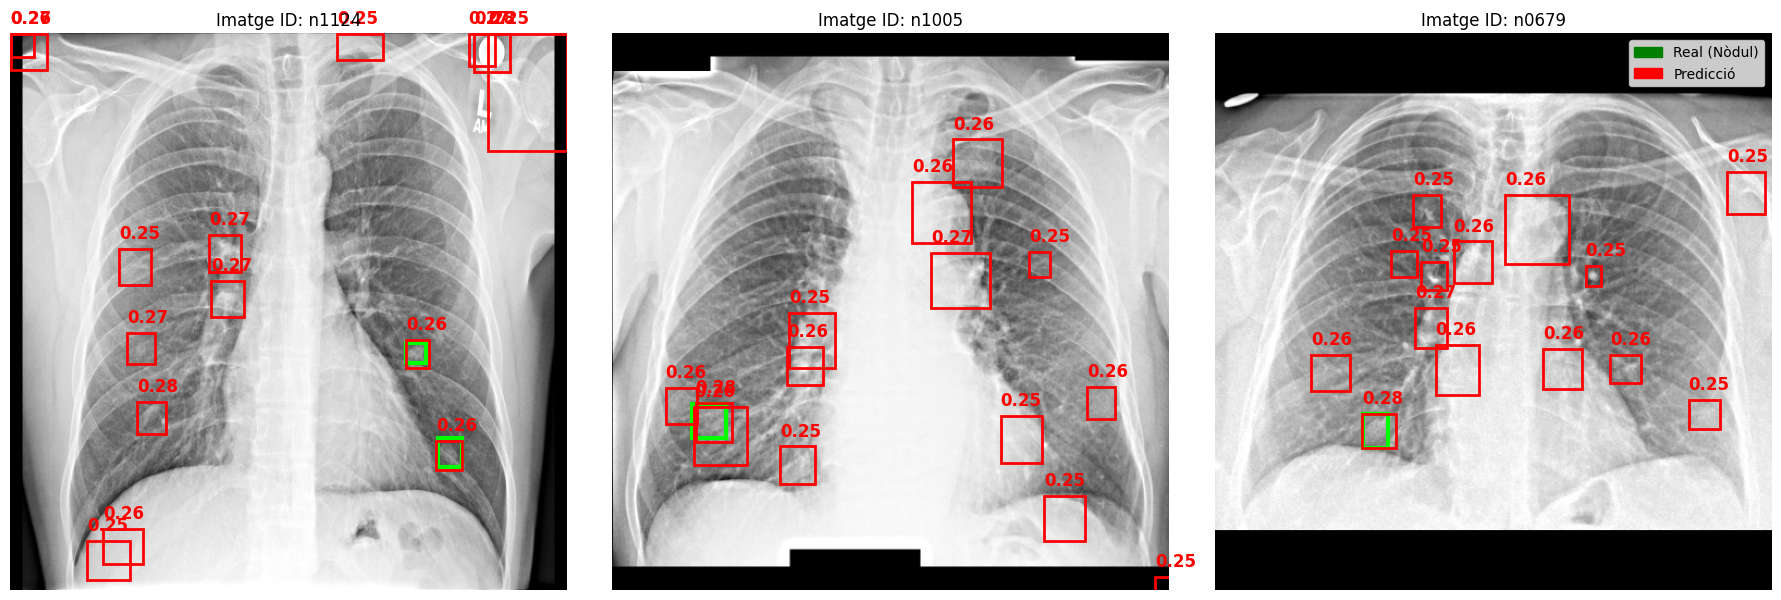

In [41]:
Utils.visualize_positive_predictions(SSDVGG_model, val_det_dataset, device, num_images=3, threshold=0.25)

In [42]:
# Fase 2: Refinament amb imatges positives i negatives (mix equilibrat)

optimizer = Utils.make_optimizer_detection(SSDVGG_model, lr=1e-3,momentum=0.9, weight_decay=5e-4)

print("\nIniciant FASE 2: Refinament amb imatges sanes i malaltes...")
history2 = Utils.fit_det(
    model=SSDVGG_model,
    train_loader=train_mix_loader,
    val_loader=val_det_loader,
    optimizer=optimizer,
    epochs=5,
    device=device
)

torch.save(SSDVGG_model.state_dict(), "ssdvgg16_phase2.pth")


Iniciant FASE 2: Refinament amb imatges sanes i malaltes...


Èpoques:  20%|██        | 1/5 [05:22<21:29, 322.26s/it]

[Època 1] Train loss 3.5494 (bbox_regression:1.2027 | classification:2.3467)  ||  Val loss 3.2459 (bbox_regression:1.2911 | classification:1.9548)


Èpoques:  40%|████      | 2/5 [11:46<17:56, 358.77s/it]

[Època 2] Train loss 3.2997 (bbox_regression:0.9947 | classification:2.3050)  ||  Val loss 3.2139 (bbox_regression:1.2524 | classification:1.9615)


Èpoques:  60%|██████    | 3/5 [18:04<12:15, 367.58s/it]

[Època 3] Train loss 3.0376 (bbox_regression:0.7688 | classification:2.2688)  ||  Val loss 3.0998 (bbox_regression:1.1432 | classification:1.9566)


Èpoques:  80%|████████  | 4/5 [24:23<06:12, 372.06s/it]

[Època 4] Train loss 2.7811 (bbox_regression:0.5479 | classification:2.2332)  ||  Val loss 3.0603 (bbox_regression:1.1119 | classification:1.9484)


Èpoques: 100%|██████████| 5/5 [30:37<00:00, 367.55s/it]

[Època 5] Train loss 2.5786 (bbox_regression:0.3932 | classification:2.1854)  ||  Val loss 3.0246 (bbox_regression:1.0761 | classification:1.9485)


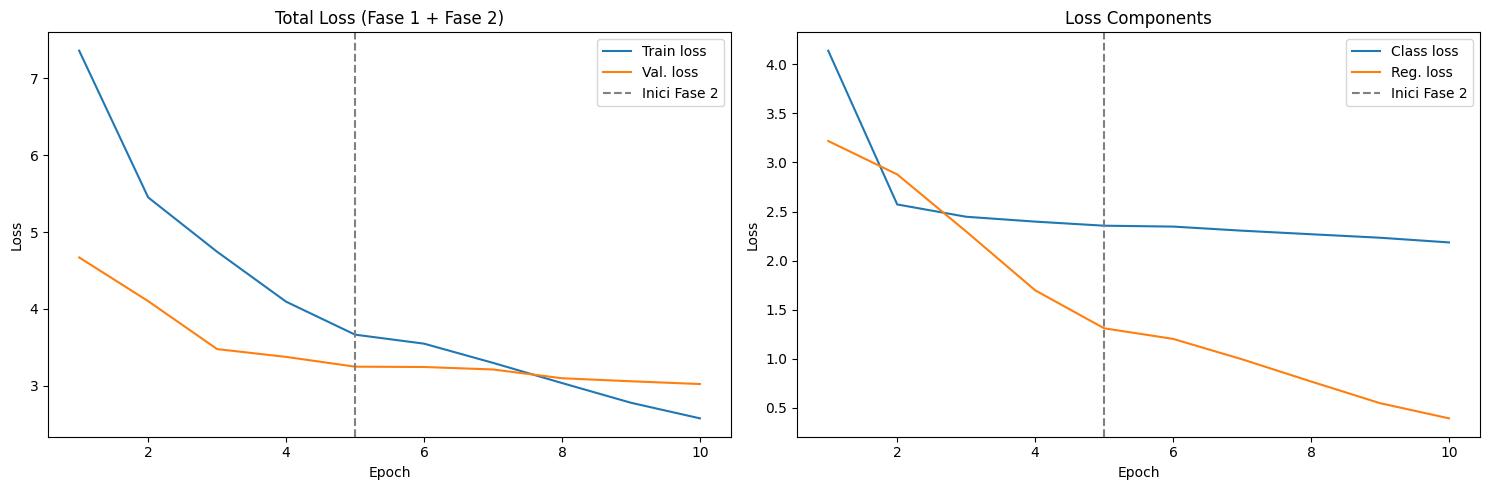

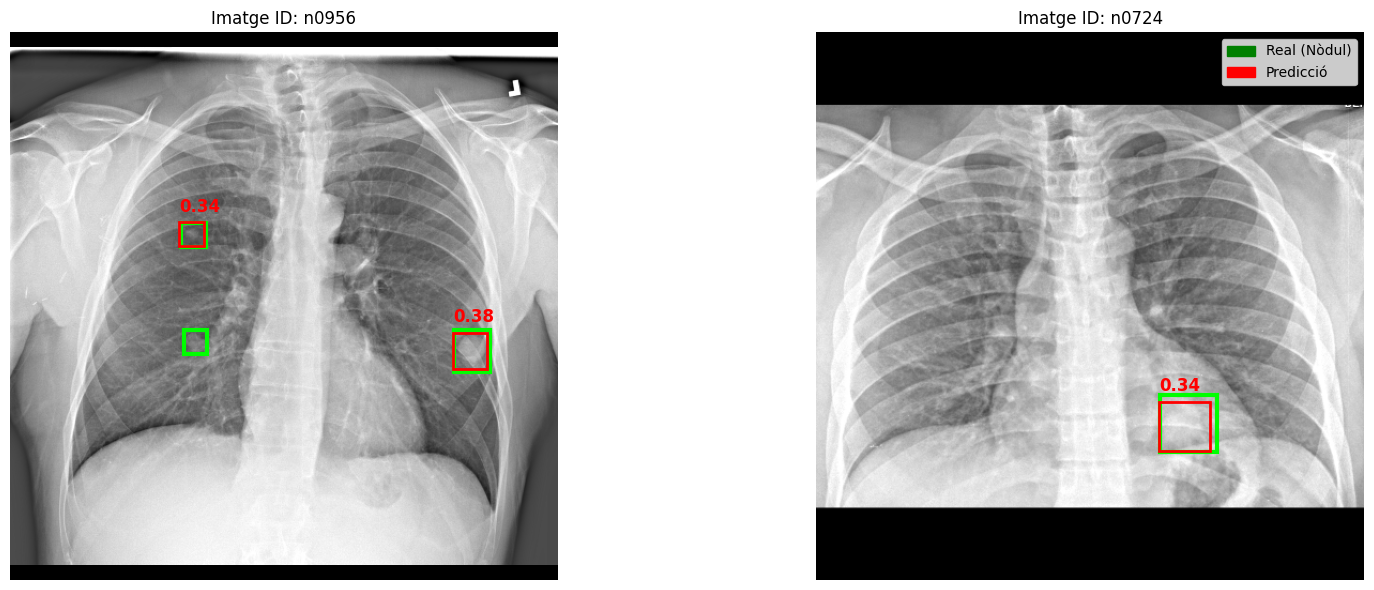

In [58]:
Utils.plot_combined_history(history, history2)
Utils.visualize_positive_predictions(SSDVGG_model, val_det_dataset, device, num_images=2, threshold=0.30)

### Model 1

#### Capes de detecció `RetinaNet + ResNet50-FPN` amb transfer learning per a detecció de nòduls (CXR)

- **Entrada**: radiografies de tòrax en escala de grisos, convertides a **3 canals**, amb forma **[3, H, W]** (H=W=512).
- **Sortida**: detecció d’objectes, amb:
  - caixes delimitadores (*bounding boxes*) de possibles nòduls,
  - puntuació de confiança,
  - etiqueta de classe (**background** o **nòdul**).
- **Idea general**: model de **detecció d’objectes one-stage** basat en **RetinaNet**, amb un backbone **ResNet50 + FPN preentrenat**, adaptat mitjançant transfer learning per a la detecció de nòduls pulmonars en radiografies.


Aquest model aborda el problema de la detecció de nòduls de manera explícita, és a dir, no només determina si hi ha un nòdul present a la imatge, sinó que també **localitza la seva posició** mitjançant caixes delimitadores. Això suposa un pas més enllà respecte als models de classificació binària.


El model utilitzat és **RetinaNet amb backbone ResNet50 i Feature Pyramid Network (FPN)**. RetinaNet és un detector *single-shot* que realitza la detecció en una sola passada per la xarxa, però a diferència d’altres detectors one-stage, introdueix la **Focal Loss**, una funció de pèrdua dissenyada específicament per tractar el fort desbalanç entre *background* i objectes d’interès.


El backbone **ResNet50** està **preentrenat en ImageNet**, cosa que permet reutilitzar característiques visuals generals (vores, textures i estructures) apreses en un gran conjunt de dades. La incorporació de la **FPN** permet combinar informació a múltiples escales, fet clau en aquest problema, ja que els nòduls poden aparèixer amb mides molt diferents dins la radiografia.


En aquesta implementació **no es construeix el model des de zero**, sinó que s’utilitza directament l’arquitectura `retinanet_resnet50_fpn_v2` proporcionada per `torchvision`. Les modificacions realitzades se centren en adaptar el detector al problema concret de detecció de nòduls.


En primer lloc, s’ha redefinit l’**anchor generator**, especificant mides d’àncores petites i mitjanes (`8, 16, 32, 64, 128`). Aquesta elecció està orientada a millorar la detecció de nòduls, que solen ocupar regions relativament petites dins la imatge. També es mantenen diversos **aspect ratios** per capturar variabilitat en la forma de les lesions.


A continuació, s’ha adaptat el **capçal de classificació** perquè el model treballi amb **2 classes**:
- `0`: background,
- `1`: nòdul.

Aquest capçal s’encarrega d’assignar una classe a cada àncora generada a diferents escales. Paral·lelament, el **capçal de regressió** s’ha redefinit per predir les coordenades de les caixes delimitadores associades a cada àncora, mantenint la coherència amb el nou esquema d’àncores.


El mètode `forward` segueix l’API estàndard dels models de detecció de `torchvision`:

- durant l’entrenament, rep:
  - una llista d’imatges,
  - una llista de diccionaris amb caixes (`boxes`) i etiquetes (`labels`);
- durant la inferència, retorna:
  - les caixes detectades,
  - les puntuacions de confiança,
  - i les classes predites.


En conjunt, l’ús de **RetinaNet amb ResNet50-FPN i transfer learning** permet abordar la detecció de nòduls de manera robusta, gestionant de forma efectiva el desbalanç entre fons i objectes d’interès i aprofitant informació multi-escala, aspectes clau en radiografies de tòrax.


### Model 2

#### Model de detecció `SSD300 + VGG16` amb transfer learning per a detecció de nòduls (CXR)

- **Entrada**: radiografies de tòrax en escala de grisos, convertides a **3 canals** i amb forma **[3, H, W]**.
- **Sortida**: detecció d’objectes, amb:
  - caixes delimitadores (*bounding boxes*) de nòduls,
  - etiqueta de classe (**background** o **nòdul**).
- **Idea general**: model de **detecció d’objectes** basat en **SSD (Single Shot Detector)** amb un backbone **VGG16 preentrenat**, adaptat mitjançant transfer learning per detectar nòduls pulmonars en radiografies.


Aquest model suposa un canvi respecte als models anteriors de classificació. En lloc de decidir únicament si una imatge conté o no un nòdul, l’objectiu és **localitzar explícitament la regió de la imatge on apareix el nòdul**, mitjançant una caixa delimitadora, a més d’assignar-li una classe.


El model utilitzat és **SSD300 amb backbone VGG16**, una arquitectura clàssica i àmpliament validada per a detecció d’objectes. SSD és un detector de tipus *single-shot*, és a dir, realitza la detecció en una sola passada per la xarxa, sense etapes separades de proposta de regions. Això el fa més simple i eficient que altres enfocaments de dues etapes.


El backbone **VGG16** està **preentrenat en ImageNet**, fet que permet reutilitzar característiques visuals bàsiques com vores, textures i patrons de forma. Aquest ús de **transfer learning** és especialment avantatjós en contextos mèdics, on el nombre d’imatges anotades amb caixes delimitadores sol ser limitat i costós d’obtenir.


El model preentrenat espera **imatges de 3 canals**, ja que ha estat entrenat amb imatges RGB. Com que les radiografies són en escala de grisos, les imatges es converteixen de **[1, H, W] a [3, H, W]** repetint el canal. Aquesta estratègia permet reutilitzar directament els pesos preentrenats sense modificar les capes convolucionals inicials del backbone.


En aquesta implementació **no es redefineix el model des de zero**, sinó que s’utilitza directament l’arquitectura `ssd300_vgg16` proporcionada per `torchvision`. La principal modificació realitzada és l’adaptació del **capçal de classificació** del detector.


Concretament, s’ha substituït la **classification head** original del model per una nova capçalera compatible amb el problema plantejat. SSD utilitza múltiples mapes de característiques a diferents escales, i per a cada nivell prediu:

- les coordenades de les caixes delimitadores,
- la classe associada a cada àncora (*anchor*).

En aquest cas, el nombre de classes s’ha ajustat a **2 classes**:
- `0`: background,
- `1`: nòdul.


Per mantenir la coherència amb l’arquitectura original, s’han reutilitzat:
- els **canals d’entrada** de cada nivell de feature maps,
- el **nombre d’àncores per localització** definit per l’anchor generator original.

A partir d’això, es construeix una nova `SSDClassificationHead` amb el nombre de classes adequat al problema de detecció de nòduls, sense alterar l’estructura interna del detector.


El mètode `forward` del model segueix l’API estàndard de detecció de `torchvision`:

- durant l’entrenament, rep:
  - una llista d’imatges,
  - una llista de diccionaris amb les caixes (`boxes`) i les etiquetes (`labels`);
- durant la inferència, retorna:
  - les caixes detectades,
  - les puntuacions (*scores*),
  - i les classes predites.


En conjunt, aquest model permet abordar el problema de manera més completa que la classificació binària, ja que no només indica la presència d’un nòdul, sinó que també **localitza la seva posició dins la radiografia**.

L’ús de **transfer learning amb SSD300 + VGG16** ofereix un bon compromís entre capacitat del model, estabilitat d’entrenament i disponibilitat de pesos preentrenats, fent-lo una elecció adequada per a una pràctica de detecció de nòduls en imatges de RX de tòrax.




## Innovació

### Explicabilitat del model amb Grad-CAM en imatges mèdiques

En l’àmbit de la imatge mèdica, no és suficient que un model obtingui bones mètriques de rendiment. És fonamental poder **entendre i justificar per què el model pren una determinada decisió**, especialment en contextos clínics on les prediccions poden influir en diagnòstics o decisions terapèutiques. Per aquest motiu, la incorporació de tècniques d’**explicabilitat** és una innovació rellevant i necessària.


#### Objectiu de l’explicabilitat

L’objectiu principal de l’explicabilitat és proporcionar una **interpretació visual** del procés de decisió del model. En el cas de la classificació de nòduls pulmonars, es vol saber **quines regions de la radiografia han estat més determinants** perquè el model decideixi que una imatge conté un nòdul.

Això permet:
- validar que el model es fixa en zones anatòmicament coherents,
- detectar possibles biaixos o *shortcut learning*,
- augmentar la confiança en el sistema per part de professionals sanitaris.


#### Funcionament general de Grad-CAM

Grad-CAM (*Gradient-weighted Class Activation Mapping*) és una tècnica que genera un **mapa de calor** sobre la imatge d’entrada, indicant quines zones han contribuït més a la predicció d’una classe concreta.

El seu funcionament general és el següent:
1. Es selecciona una **capa convolucional profunda** del model (en aquest cas, l’última capa convolucional de ResNet).
2. Es calculen els **gradients de la sortida (classe d’interès)** respecte a les activacions d’aquesta capa.
3. Aquests gradients s’utilitzen per ponderar les activacions, obtenint un mapa que destaca les regions més influents.
4. El mapa resultant es projecta sobre la imatge original per facilitar la interpretació visual.

Com que les capes convolucionals mantenen informació espacial, Grad-CAM és especialment adequat per a tasques de visió artificial com la classificació d’imatges mèdiques.

#### Valor afegit de l’explicabilitat

La incorporació de Grad-CAM aporta un valor afegit clar al sistema desenvolupat:
- millora la transparència del model,
- facilita la detecció d’errors conceptuals,
- i fa el sistema més acceptable en un entorn mèdic real.

En resum, l’ús d’explicabilitat mitjançant Grad-CAM no només complementa el rendiment quantitatiu del model, sinó que el converteix en una eina més fiable, interpretable i alineada amb les necessitats del sector sanitari.


Visualitzant Grad-CAM per la imatge índex 1...


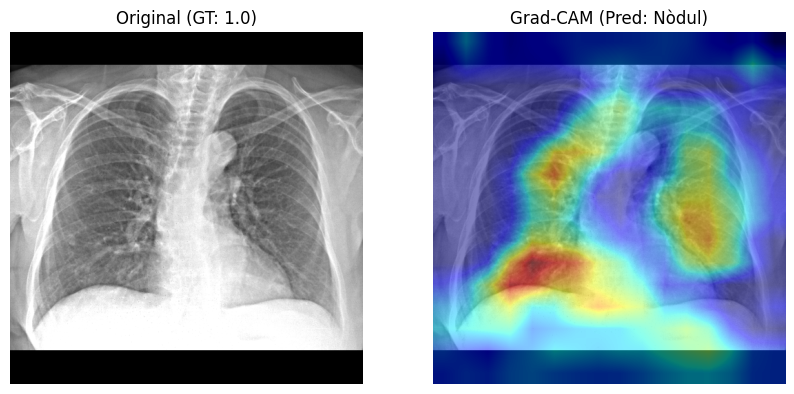

In [95]:
# Carrega el teu model de Classificació (ex: ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Models.ResNet18Binary().to(device)
model.eval()

# Definim quina és la "Target Layer" (l'última capa convolucional)
# Per a ResNet18Binary (tal com el tenim definit al Models.py):
target_layer = model.backbone.layer4[-1] 

# Cercam una imatge positiva (Nòdul) per visualitzar
# Iteram pel dataset fins trobar un nòdul (label 1)
idx_nodul = 0
for i in range(len(val_dataset)):
    if val_dataset[i][1] == 1: # Si l'etiqueta és 1
        idx_nodul = i
        break

print(f"Visualitzant Grad-CAM per la imatge índex {idx_nodul}...")

# Cridam la funció que hem creat al Utils
Utils.show_gradcam(model, val_dataset, device, img_index=idx_nodul, target_layer=target_layer)